In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [29]:
# Sample 2D projected points (v_x, v_y) and feature vectors (g_x, g_y)
n_points = 100
v_x, v_y = np.random.rand(n_points), np.random.rand(n_points)
g_x, g_y = np.random.randn(n_points), np.random.randn(n_points)

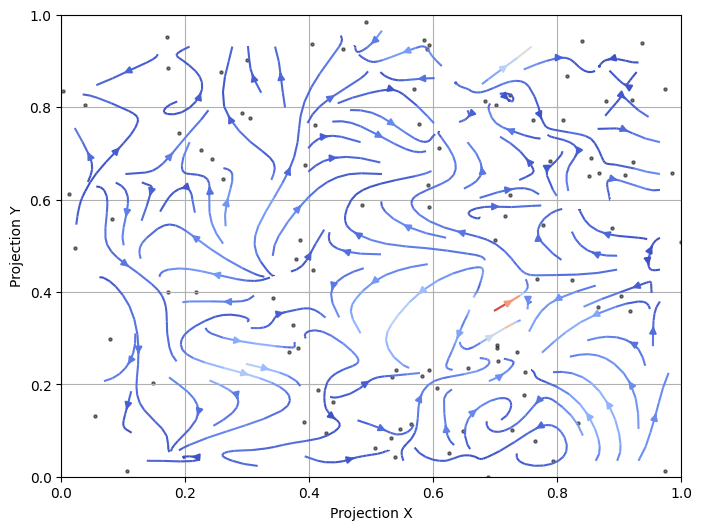

In [51]:
# Define a uniform grid
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))

# Interpolate feature vectors onto the grid
grid_gx = griddata((v_x, v_y), g_x, (grid_x, grid_y), method='cubic')
grid_gy = griddata((v_x, v_y), g_y, (grid_x, grid_y), method='cubic')

# Plot the feature map with streamlines
plt.figure(figsize=(8, 6))
plt.streamplot(grid_x, grid_y, grid_gx, grid_gy, color=np.hypot(grid_gx, grid_gy), cmap='coolwarm')
# plt.scatter(grid_x, grid_y, s=5, c='blue', alpha=0.3, label='Grid Points')
plt.scatter(v_x, v_y, c='black', s=5, alpha=0.5)
# plt.quiver(v_x, v_y, g_x, g_y, color='red', scale=10)
plt.grid(True)
plt.xlabel("Projection X")
plt.ylabel("Projection Y")
# plt.colorbar(label="Feature Influence Magnitude")
plt.show()

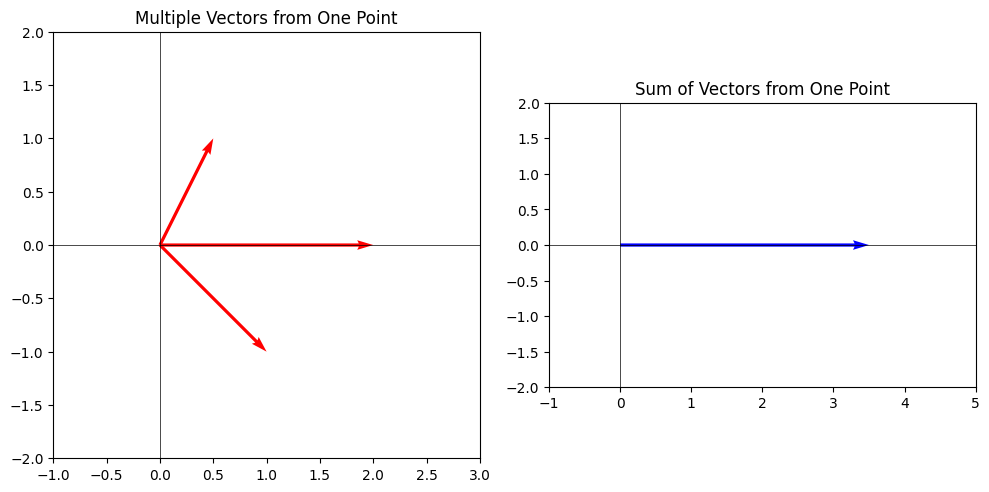

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Define vectors
v1 = np.array([1, -1])
v2 = np.array([0.5, 1])
v3 = np.array([2, 0])
vectors = [v1, v2, v3]
sum_vector = np.sum(vectors, axis=0)

plt.figure(figsize=(10, 5))

# 1) Several vectors attached to a point
plt.subplot(1, 2, 1)
plt.title("Multiple Vectors from One Point")
for v in vectors:
    plt.quiver(0, 0, v[0], v[1], angles='xy', scale_units='xy', scale=1, color='red')
plt.xlim(-1, 3)
plt.ylim(-2, 2)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')

# 2) Add all vectors to form a single vector
plt.subplot(1, 2, 2)
plt.title("Sum of Vectors from One Point")
plt.quiver(0, 0, sum_vector[0], sum_vector[1], angles='xy', scale_units='xy', scale=1, color='blue')
plt.xlim(-1, 5)
plt.ylim(-2, 2)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()